In [1]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import yfinance as yf
import pandas as pd
import ast
import os
import talib
import numpy as np
from datetime import datetime as dt
from scipy.linalg import sqrtm
from numpy import linalg as LA
from scipy.stats import pearsonr
from pandas_datareader import data as pdr
from sklearn.decomposition import SparsePCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import cvxpy as cp

import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel

from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore
#import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import multiprocessing
#import pyfolio as pf
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission

In [3]:
bundle = 'quandl'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [4]:
def initialize(context):
    context.asset = symbol('AAPL')
    context.idx = 0
    # Add Slippage and Commsision
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    pricedic = {}
    if context.idx % 13 == 0:
        order_target_percent(context.asset, 0.5)
        pricedic[context.asset] = (data.current(context.asset, 'price'))
    elif context.idx % 17 == 0:
        order_target_percent(context.asset, -0.5)
        pricedic[context.asset] = (data.current(context.asset, 'price'))
    
    context.idx += 1
    record(PRI=pricedic)

start = pd.Timestamp('2010-01-05')
end = pd.Timestamp('2015-01-01')
capital_base = 1000000

results = run_algorithm(start = start,
                        end = end,
                        initialize = initialize,
                        handle_data = handle_data,
                        capital_base=capital_base,
                        trading_calendar= calendar,
                        bundle = 'quandl',
                        data_frequency= 'daily')



[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-06   2010-01-06
End Period                 2014-12-31   2014-12-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          81.16%       32.67%
Active Return              0.0%         -48.49%
CAGR﹪                     8.58%        3.99%

Sharpe                     0.83         0.49
Prob. Sharpe Ratio         96.58%       86.61%
Smart Sharpe               0.81         0.49
Sortino                    1.16         0.73
Smart Sortino              1.14         0.71
Sortino/√2                 0.82         0.51
Smart Sortino/√2           0.81         0.5
Omega                      1.09         1.09

Max Drawdown               -19.39%      -17.31%
Longest DD Days            298          497
Volatility (ann.)          16.0%        13.25%
R^2                        0.01         0.01
Information Ratio 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2011-08-09,2012-02-14,2012-12-17,497,-17.307762,-16.560731
2,2010-08-02,2010-11-17,2011-08-04,368,-13.404158,-12.497122
3,2013-03-12,2013-04-19,2013-07-26,137,-13.240084,-13.075312
4,2013-08-12,2013-09-16,2014-01-27,169,-12.257901,-10.898485
5,2010-01-20,2010-05-07,2010-06-16,148,-11.186677,-9.377225


Slippage: 6.939005025607315
Slippage Lost: -163.66269799883872
Total Commission: 1585.1460000000002


Average Long Exposure = 346820.78494112974
Average Short Exposure = -189559.72855767704
Average Net Leverage = 0.14832266786142775
Average Gross Leverage = 0.5011444702606682
Max Leverage = 0.5882018655761561



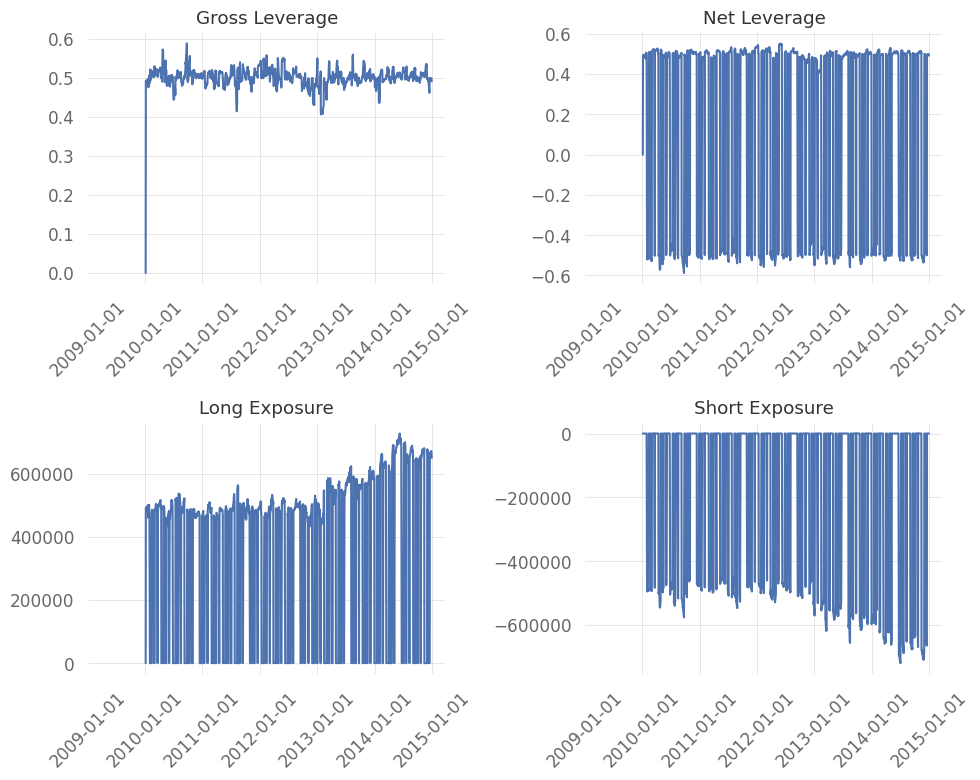

AAPL





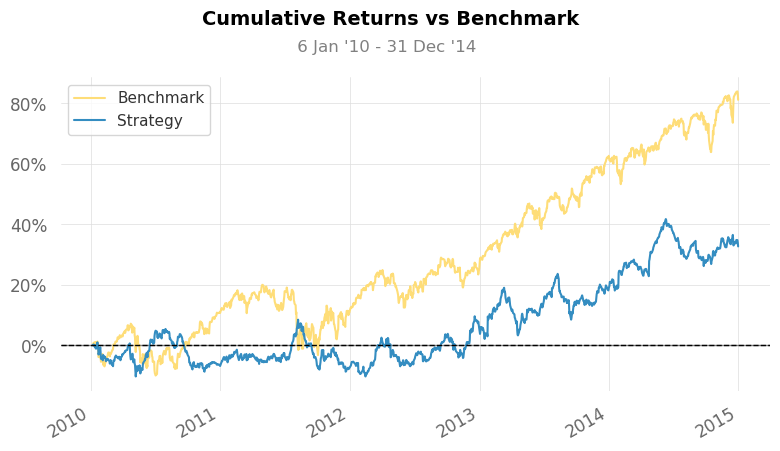

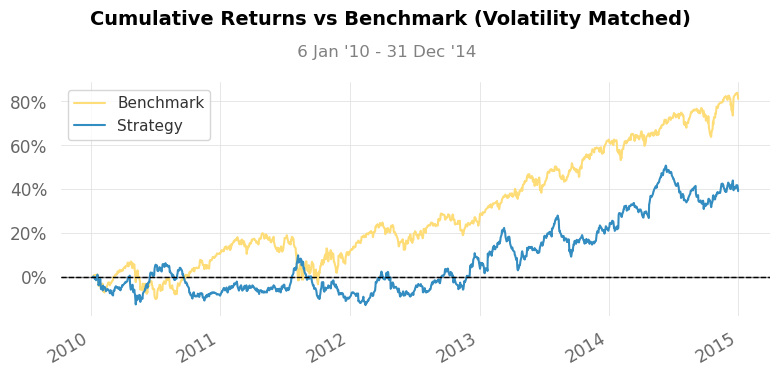

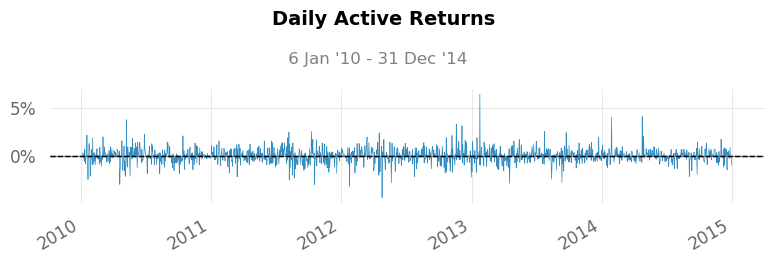

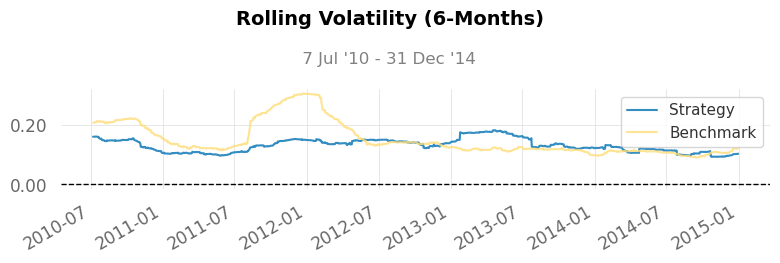

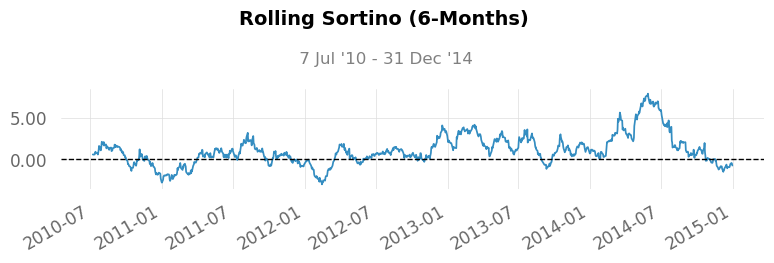

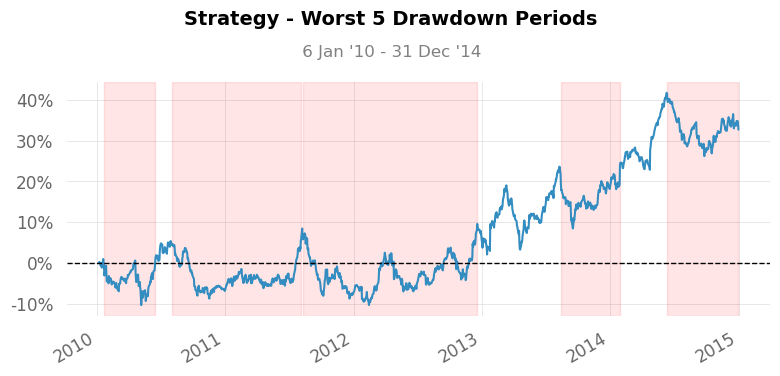

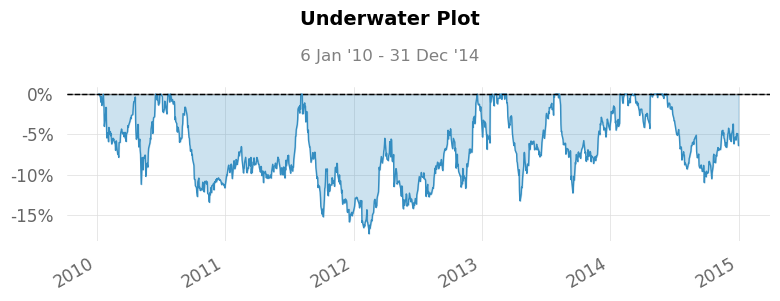

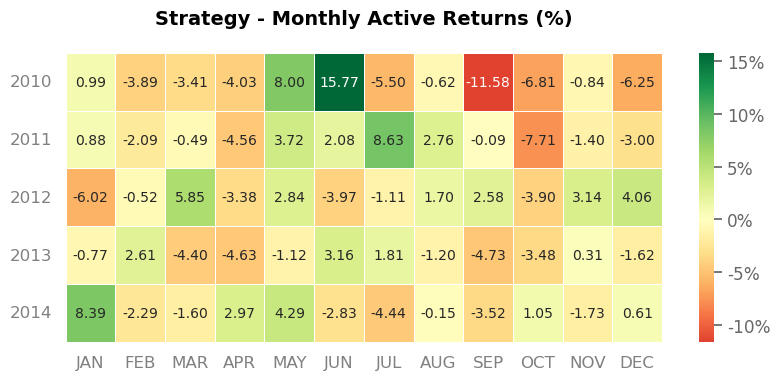

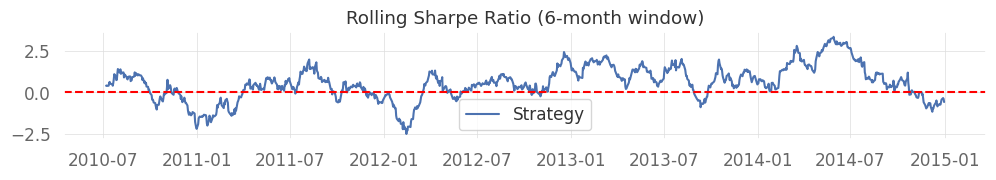

[*********************100%***********************]  1 of 1 completed


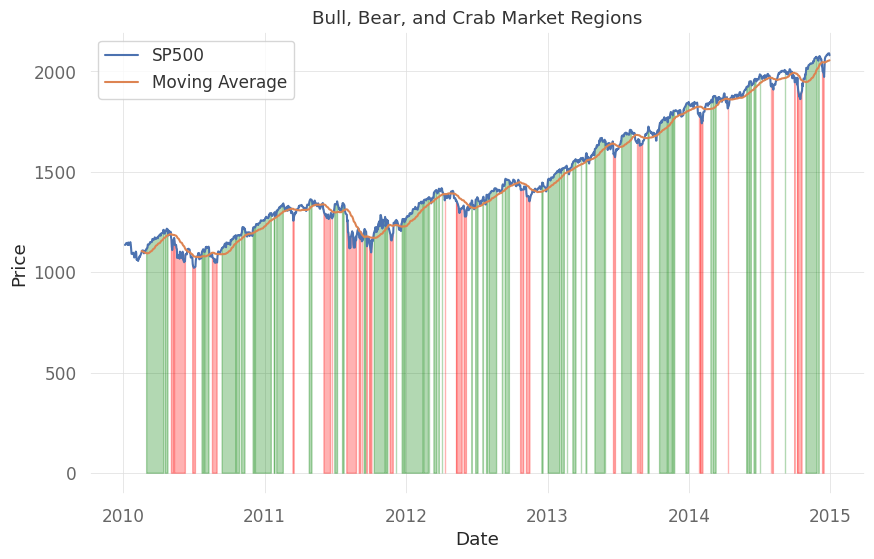

Total Trades: 164
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





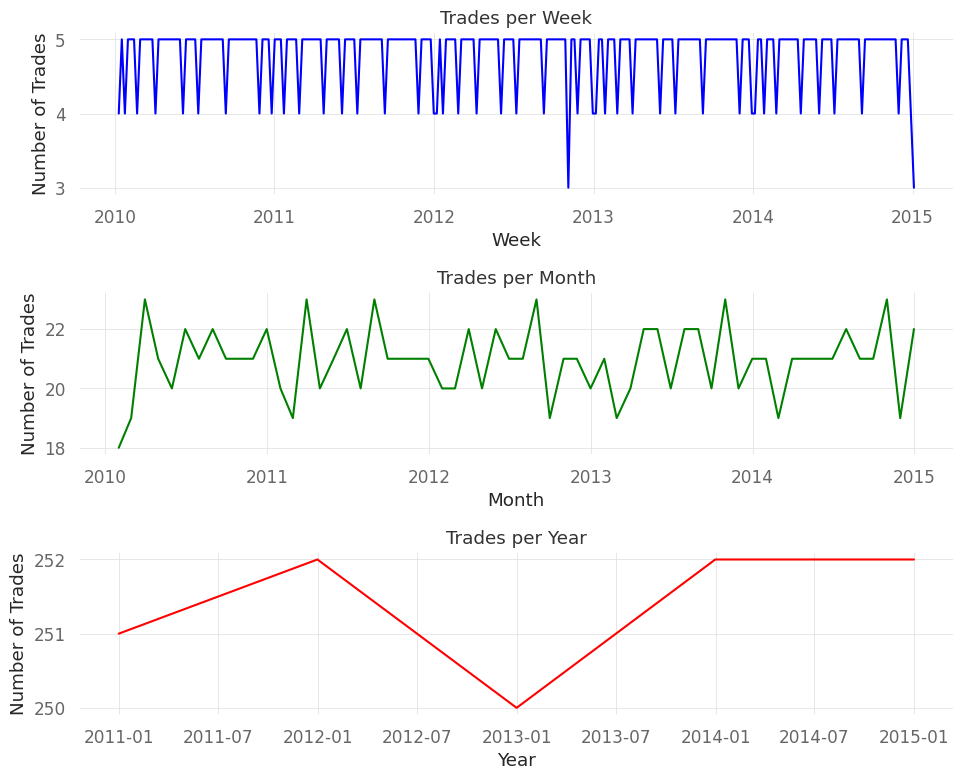

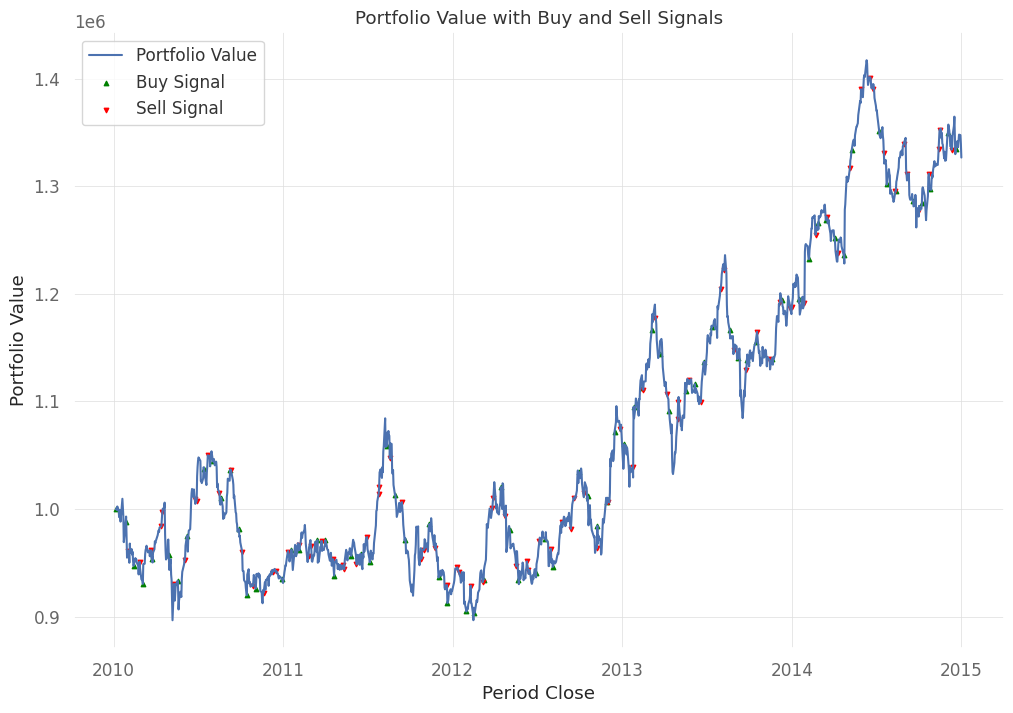

In [5]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)
